In [4]:
## Basic LieGan implementation adapted from https://github.com/Rose-STL-Lab/LieGAN
import os
import math
from collections.abc import Iterable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import argparse
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from gan import LieGenerator, LieDiscriminator, LieDiscriminatorEmb, LieDiscriminatorConv
import matplotlib.pyplot as plt
import argparse

###########################################################################################
# Taken from https://github.com/Rose-STL-Lab/LieGAN/blob/master/main_lagan.py
###########################################################################################
class Args:
    def __init__(self):
        # training settings
        self.batch_size = 512
        self.num_epochs = 100
        self.lr_d = 2e-4
        self.lr_g = 1e-3
        self.reg_type = 'cosine'
        self.lamda = 1e-2
        self.p_norm = 2
        self.droprate_init = 0.8
        self.mu = 0.0
        self.activate_threshold = False
        self.D_loss_threshold = 0.25
        self.model = 'lie'
        self.coef_dist = 'normal'
        self.g_init = 'random'
        self.sigma_init = 1
        self.uniform_max = 1
        self.normalize_Li = False
        self.augment = False
        self.n_channel = 1
        self.eta = 1.0
        self.incremental = False

        # dataset settings
        self.task = 'traj_pred'
        self.dataset_name = '2body'
        self.dataset_config = None
        self.dataset_size = 2000
        self.x_type = 'vector'
        self.y_type = 'vector'
        self.input_timesteps = 1
        self.output_timesteps = 1
        self.n_component = 1
        self.noise = 0.0

###########################################################################################
###########################################################################################
class DiscreteRotation(torch.utils.data.Dataset):
    def __init__(self, N=2000, k=7):
        self.X = np.random.randn(N, 3)
        self.y = np.arctan2(self.X[:, 1], self.X[:, 0])
        self.y = self.X[:, 2] / (1 + np.mod(self.y, 2 * np.pi / k))
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
        self.N = N

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NDegreeRotation(torch.utils.data.Dataset):
    def __init__(self, N=2000, order=2):
        
        self.X = np.random.randn(N, order)
        self.y = np.sum(self.X**2,axis = 1)
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
        self.N = N

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
###########################################################################################
###########################################################################################
def train_using_LieGAN(args,data,batch_size,generator,discriminator):
    
    # Loss function
    adversarial_loss = torch.nn.BCELoss(reduction='mean')
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr_g, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr_d)
    train_generator = train_discriminator = True
    
    for ep in tqdm(range(0,args.num_epochs)):
        D_real_loss_list, D_fake_loss_list, G_loss_list, G_reg_list, G_spreg_list, G_chreg_list = [], [], [], [], [], []
        
        index = torch.randperm(data[0].shape[0])
        
        for i in range(0,(index.shape[0]//batch_size)+1):
            
            x,y = data[0][index[i*batch_size:(i+1)*batch_size],:],data[1][index[i*batch_size:(i+1)*batch_size]]
            
            bs = x.shape[0]
            # Adversarial ground truths
            valid = torch.ones(bs, 1, device=device)
            fake = torch.zeros(bs, 1, device=device)
            
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            # Generate a batch of transformed data points
            gx, gy = generator(x, y)
            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gx, gy), valid)
    
            g_reg = torch.abs(nn.CosineSimilarity(dim=2)(gx, x).mean())
            
            g_reg = args.lamda * g_reg
            g_chreg = args.eta * generator.channel_corr(killing=False)
            
            G_loss_list.append(g_loss.item())
            G_reg_list.append(g_reg.item() / max(args.lamda, 1e-6))
            G_chreg_list.append(g_chreg.item() / max(args.eta, 1e-6))
            g_loss = g_loss + g_reg + g_chreg
            
            g_loss.backward()
            optimizer_G.step()
            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(x, y), valid)
            fake_loss = adversarial_loss(discriminator(gx.detach(), gy.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            if train_discriminator:
                d_loss.backward()
                optimizer_D.step()
            D_real_loss_list.append(real_loss.item())
            D_fake_loss_list.append(fake_loss.item())
    return generator.getLi().cpu().detach().numpy()

    


In [5]:
p

_StoreAction(option_strings=['--store_name'], dest='store_name', nargs=None, const=None, default='generator', type=<class 'str'>, choices=None, required=False, help='Name of the generator whose weights will be stored', metavar=None)

In [2]:
device = "cuda:0"




n_dim = 2 # Dimension of the generator
n_channel = 1 # Number of generators
d_input_size = n_dim + 1 # Number of inputs to the Discriminator
generator = LieGenerator(n_dim= n_dim, n_channel=n_channel, args = args).to(device)
discriminator = LieDiscriminator(d_input_size).to(device)

dataset = NDegreeRotation(order=n_dim,N=args.dataset_size)
data = dataset.X.to(device),dataset.y.to(device)

In [3]:
gen = train_using_LieGAN(args = args,data=data,batch_size = args.batch_size,generator=generator,discriminator=discriminator)

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
np.save("./ExperimentWeights/generator.npy",gen)

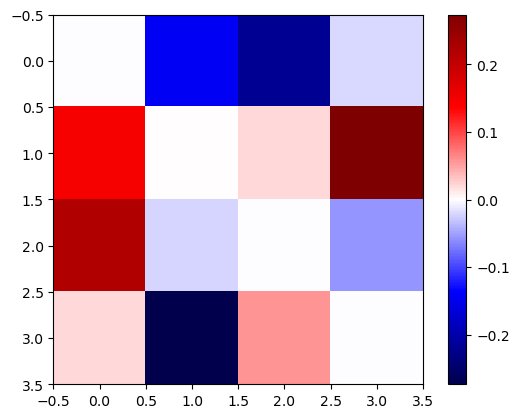

In [24]:
plt.imshow(gen[5,:,:],cmap = "seismic")
plt.colorbar()